In [2]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import multivariate_normal
import scipy.stats as stats
import time
import scipy as scipy
import sys
from math import pi
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

Populating the interactive namespace from numpy and matplotlib


# An exploration of the Intelligent Bayesian Optim
- Gaussian Process for Regression: A Quick Introduction
    - M. Ebden
- http://haikufactory.com/files/bayopt.pdf

###  Assmptions
- Prior is a Gaussian Process with mean = 0
- Pick the domain to optimize over
- Starting wit ha 1D domain

### Kernels

In [13]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = 5e-3, vertical_scale=1.5):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix.
    Vertical scale controls the vertical scale of the function"""
    if train == False:
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist)

    else:
        noisy_observations = train_noise*np.eye(len(a))
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

- Define the testing domain (test_x) as well as the training points for the 1D case

In [3]:
test_x = np.array(np.linspace(-100,100,1_000)).reshape(-1,1)
train_x = np.array([[-5]]).reshape(-1,1)

train_y_func = lambda x: 1000*sin(.1*x)/abs(x+10*x+5)
train_y_func_two_d = lambda a,b : (a*b)/(a-1/(b+1)) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = 100
max_covariance = 5


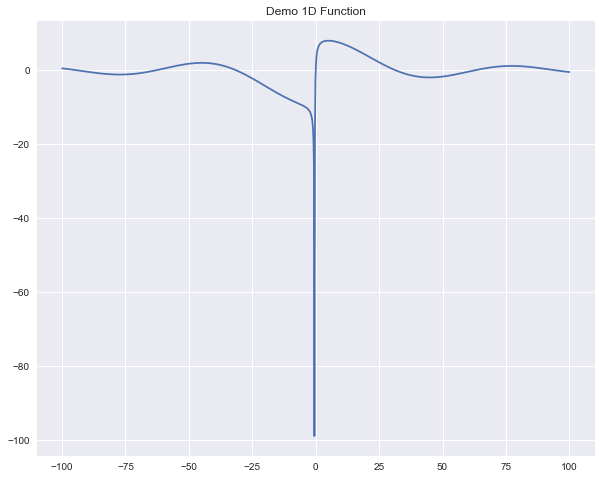

In [6]:
plt.figure(figsize=(10,8))
plt.title('Demo 1D Function')
plt.plot(np.linspace(-100,100,1_000),np.array([train_y_func(_) for _ in test_x]).reshape(-1,1) );

In [9]:
# Two dimensional training points
test_two_d_x = np.squeeze(np.array(list(itertools.product(*[test_x ,test_x ]))))
train_two_d_x = np.array(list(itertools.product(*[np.linspace(-10,10,2),np.linspace(-10,10,2)])))
train_y_numbers_two_d = np.array([train_y_func_two_d(x,y) for x,y in train_two_d_x]).reshape(-1,1)
test_y_numbers_two_d =  np.array([train_y_func_two_d(x,y) for x,y in test_two_d_x]).reshape(-1,1)

In [8]:
from numpy import linalg as la
#https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194#43244194
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [14]:
def test_gaussian_process(test_x, train_x, train_y_numbers, y_var, kernel, return_cov = False,
                          return_sample = False, covariance_noise = 5e-5, n_posteriors = 5):
    """Test one new point in the Gaussian process or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples ( a vector) from the informed posterior and the uninformed prior distribution
    
    Covariance diagonal noise is used to help enforce positive definite matrices
    
    N_posteriors indicates the number of posterior functions to create when sampling"""
    
    
    # define the covariance matrices
    covariance_train_train = kernel(train_x,train_x,train=True)
    covariance_test_train  = kernel(test_x,train_x)
    covariance_test_test  = kernel(test_x,test_x)
    

    # Use cholskey decomposition to increase speed for calculating mean
    try :# First try, 
        L_test_test = np.linalg.cholesky(covariance_test_test + covariance_noise*np.eye(len(covariance_test_test)))
        L_train_train = np.linalg.cholesky(covariance_train_train + covariance_noise*np.eye(len(covariance_train_train)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covariance matrix is not positive definite 
        # Find the near positive definite matrix to decompose
        decompose_train_train = nearestPD(covariance_train_train + covariance_noise*np.eye(len(train_x)))
        decompose_test_test = nearestPD(covariance_test_test + covariance_noise*np.eye(len(test_x)))
        
        # cholskey decomposition within the try except block
        L_train_train = np.linalg.cholesky(decompose_train_train  )
        L_test_test = np.linalg.cholesky(decompose_test_test  )
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        
        
#         ##### FULL INVERSION ####
#         mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train) @ train_y_numbers
#         s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
#                      @ covariance_test_train.T
        

    def sample_from_posterior(n_priors=3, n_post=5):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        # Draw samples from the posterior at our test points.
        covariance_test_test  = kernel(test_x,test_x)
        try: # try inside sample from posterior function
            L = np.linalg.cholesky(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
        except Exception as e:
            # Find the neareset Positive Definite Matrix
            near_decompose = nearestPD(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
            L = np.linalg.cholesky(near_decompose.astype(float) ) # within posterior
        # sample from the posterior
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample X sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        # For the posterior, the columns are the vector for that function
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        f_prior, f_post = sample_from_posterior(n_post = n_posteriors)
        return mus.ravel(), s2.ravel(), f_prior, f_post
    else:
        return mus.ravel(), s2.ravel()
    
   

### Show the posterior learning the true underlying function with a squarred (RBF) kernel

In [15]:

def sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process,kernel, range_to_sample=np.linspace(-100,100,25)):
    """Plot potential posterior functions after sampling from the true function.
    Notice how the varaince decreases around the sampled points"""
    # one d
    train_x = np.array(np.linspace(-100,100,1)).reshape(-1,1)
    train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
    
#     # TWO D
#     train_x = np.array([[1,2],[2,1]])
#     train_y_numbers = np.array([train_y_func(x,y) for x,y in train_x]).reshape(-1,1)

    # shuffle the range
    shuffle(range_to_sample)
    # go through the points in the range
    for sampled_point in range_to_sample:
        # ONE D
        print(f"Point Sampled x = {train_x.ravel()[-1]}")
        
        
        m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,kernel, return_sample = True)

        plt.figure(figsize=(15,4))

        plt.gca().fill_between(test_x.flat, m-2*np.sqrt(var), m+2*np.sqrt(var), color="#dddddd",label='95% confidence')
        plt.scatter(train_x.ravel(), train_y_numbers,marker='*',label='Samples', linewidth=5, color='red')

        plt.plot(np.linspace(-100,100,400),[train_y_func(i) for i in np.linspace(-100,100,400)], label='real function',
                linestyle="--")
        plt.plot(test_x,post,color='black',label='Draws from the posterior')
        #plt.scatter(train_x,train_y_numbers)
        #plt.scatter(test_x,m,label='MU',color='red', linewidth=10, marker='*');
        plt.legend()
        plt.title('Posteriors, and Actual Function')

        plt.show();

        # Update training data with the sampled point
        train_x = train_x.ravel()
        train_x = np.append(train_x,sampled_point)
        train_x = train_x.reshape(-1,1)
        train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)

        # sleep for three seconds
        time.sleep(1)

In [16]:
m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

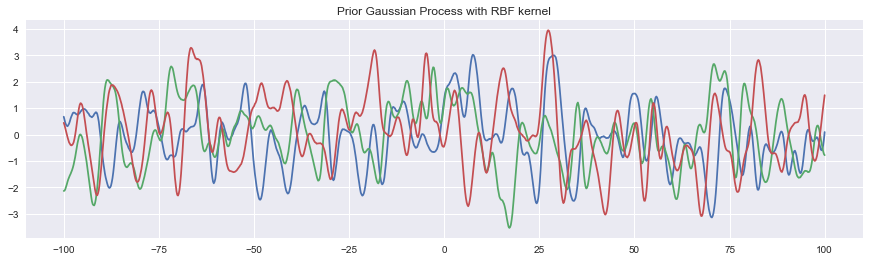

In [17]:
plt.figure(figsize=(15,4))
plt.title('Prior Gaussian Process with RBF kernel')
plt.plot(test_x, prior);

Point Sampled x = -100.0


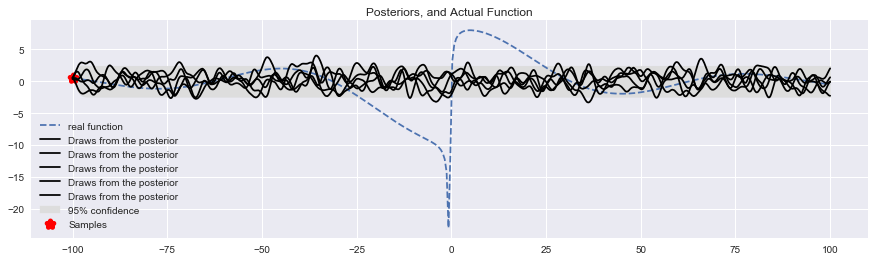

Point Sampled x = -33.33333333333333


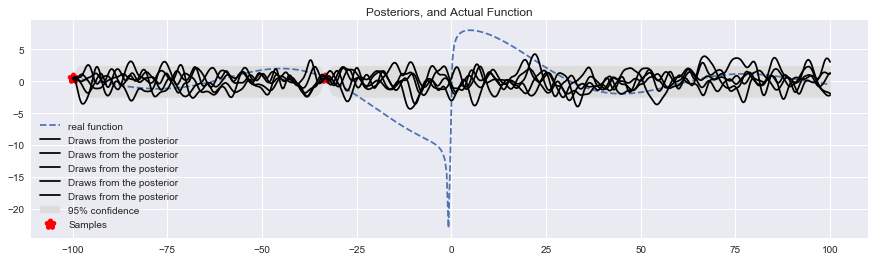

KeyboardInterrupt: 

In [18]:
# one dimensional
sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process, squarred_kernel)

### Best estimate for Y* is given by the mean of the distribution


### Implement Expected Improvement


In [19]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist=None, point_est = False):
    """Finds the expected improvement of a point give the current best point.
    If point_est = False, then computes the expected value on a vector from the posterior distribution.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        # Expected val for one point
        if point_est ==True:
            sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

            Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x

            if round(sigma_x,8) == 0:
                return 0
            else:
                return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

        else:
            # Sample from the posterior functions
            for _ in range(len(mean_x)):
                list_of_improvements = []
                m_s = []
                for m,z,s in zip(mean_x, ((mean_x -y_val_for_best_hyperparameters)\
                                     / np.std(sigma_squarred_x)),np.sqrt(sigma_squarred_x) ):
                    
                    list_of_improvements.append(((m-y_val_for_best_hyperparameters)*norm().cdf(z)\
                                                 +s*norm().pdf(z)))
                    m_s.append(m)

                return list_of_improvements

In [21]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, kernel, y_var, testing_domain = range(-100,100,10), n = 20,
                        verbose=True):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    Verbose signifies if the function should print out the points where it is sampling
    
    Returns a generator of x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
          for improvements. Mus and Vars are the mean and var for each sampled point in the gaussian process. 
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest expected improvement.
    
    Note - the y-function can EITHER by the actual y-function (for evaluation purposes, or an objective function 
    (i.e. - RMSE))"""
  
    
    # best points so far
    x_sampled_points = []
    y_sampled_points = []        
    best_x = train_x[np.argmax(train_y_numbers),:]
    best_y =train_y_numbers[np.argmax(train_y_numbers ),:]


    

    for i in range(n):
        if i == 0:
            if train_x.shape[1]==1: ## one dimensional case
                testing_domain = np.array([testing_domain]).reshape(-1,1)
                        
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)
            
           
            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post ,best_y)

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            # don't resample the same point
            c = 1
            while max_improv_x in x_sampled_points:
                if c == 1:
                    if self.train_points_x .shape[1]==1:
                        sorted_points_idx = np.argsort(list(np.array(
                            list_of_expected_improvements)))
                    else:
                        sorted_points_idx = np.argsort(list(np.array(
                            list_of_expected_improvements)),axis=0)
                c+=1
                max_improv_x_idx = int(sorted_points_idx[c])
                max_improv_x = testing_domain[max_improv_x_idx]
                # only wait until we've gon through half of the list
                if c > round(len(list_of_expected_improvements)/2):
                    max_improv_x_idx = int(
                        np.argmax(list_of_expected_improvements))
                    max_improv_x = testing_domain[max_improv_x_idx]
                    break
            
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                try: # see if we are passing in the actual function
                    max_improv_y = y_function(max_improv_x[0], max_improv_x[1])
                except: # we are passing the objective function in     
                    max_improv_y = y_function(max_improv_x[0],dimensions = 'two', 
                                              hyperparameter_value_two = max_improv_x[1])
                
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
           
            
            if verbose:
                print(f"Bayesian Optimization just sampled point = {best_x}")
                print(f"Best x (Bayesian Optimization) = {best_x}, Best y = {best_y}")

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
                    
            else:

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
            

        else:
            # reformat testing domain to include more possible points
            if train_x.shape[1]==1:
                testing_domain = np.array([testing_domain]).reshape(-1,1)
            
            
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)

            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post, best_y)
            
            
            # find the best x value
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            # don't resample the same point
            c = 1
            while max_improv_x in x_sampled_points:
                if c == 1:
                    if self.train_points_x .shape[1]==1:
                        sorted_points_idx = np.argsort(list(np.array(
                            list_of_expected_improvements)))
                    else:
                        sorted_points_idx = np.argsort(list(np.array(
                            list_of_expected_improvements)),axis=0)
                c+=1
                max_improv_x_idx = int(sorted_points_idx[c])
                max_improv_x = testing_domain[max_improv_x_idx]
                # only wait until we've gon through half of the list
                if c > round(len(list_of_expected_improvements)/2):
                    max_improv_x_idx = int(
                        np.argmax(list_of_expected_improvements))
                    max_improv_x = testing_domain[max_improv_x_idx]
                    break
                
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                try: # see if we are passing in the actual function
                    max_improv_y = y_function(max_improv_x[0], max_improv_x[1])
                except: # we are passing the objective function in     
                    max_improv_y = y_function(max_improv_x[0],dimensions = 'two', 
                                              hyperparameter_value_two = max_improv_x[1])
                
  
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass
            if verbose:
                print(f"Bayesian Optimization just sampled point = {max_improv_x}")
                print(f"Best x (Bayesian Optimization) = {best_x}, Best y = {best_y}")

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
                    
            else:


                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
         


    

# Test Bayesian optimization, initially using squarred kernel
- One dimensional First

In [22]:
# Create the generator, ONE DIMENSIONAL
samples = 10
gen = sample_from_function(train_y_func,train_x, train_y_numbers, squarred_kernel, y_var, n=samples, 
                           testing_domain=test_x  )

STEP NUMBER =  1
Bayesian Optimization just sampled point = [ 46.94694695]
Best x (Bayesian Optimization) = [ 46.94694695], Best y = [-1.91755271]
-9.53475749663 0.0 min max mus


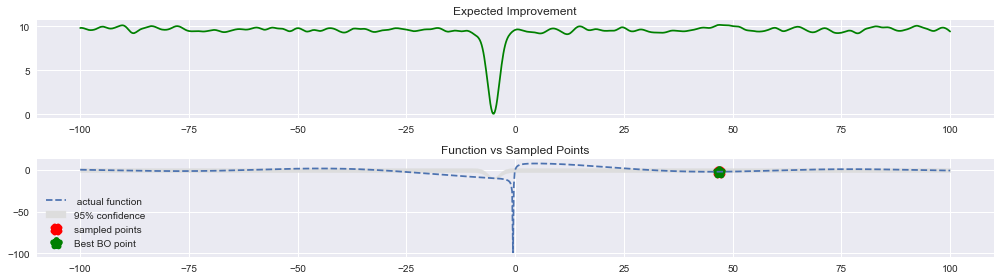

STEP NUMBER =  2
Bayesian Optimization just sampled point = [-15.91591592]
Best x (Bayesian Optimization) = [ 46.94694695], Best y = [-1.91755271]
-9.53475749663 0.0 min max mus


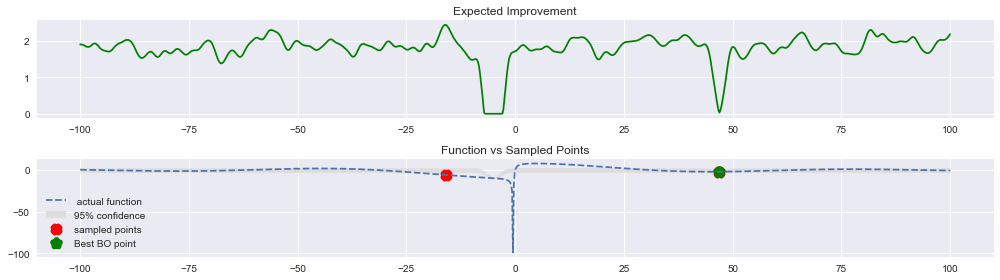

STEP NUMBER =  3


KeyboardInterrupt: 

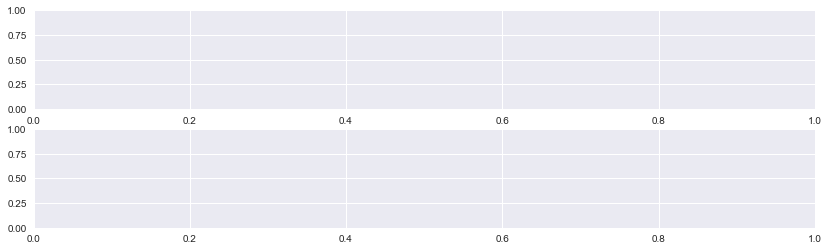

In [23]:
# Used for Expected Improvement  - One Dimensional

for i in range(samples):
    # sample from generator
    print("STEP NUMBER = ",i+1)
    fig, axs = plt.subplots(2, figsize=(14, 4))
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen)
    
    print(min(mus),max(mus),'min max mus')
        # Expectd Improvement
    #plt.figure(figsize=(12,10))
    axs[0].set_title('Expected Improvement')
    axs[0].plot(domain,improvements,label='Expected improvements',color='green')
    
    
    
     # 95% confidence bars
    #plt.figure(figsize=(12,10))
    axs[1].set_title("Function vs Sampled Points")
    plt.gca().fill_between(domain.flat, mus-2*np.sqrt(sampled_var),
                          mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    
    
    train_y_x_axis = np.array(np.linspace(-100,100,1000))
    train_y_numbers_ = [train_y_func(i) for i  in train_y_x_axis]
    
    axs[1].plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    # point sampled
    axs[1].scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    axs[1].scatter(best_x,best_y, marker = "*",label='Best BO point',linewidths=6, color = 'green')

    
    mus = np.array(mus)
    domain = np.array(domain)

    plt.legend()
    plt.tight_layout()
    
    plt.show();



# Objective Function

In [24]:
# MSE
def mean_squarred_error(actual, predicted, negative = True):
    """MSE of actual and predicted value.
    Negative turn the MSE negative to allow for maximization instead of minimization"""
    if negative == True:
        return -np.linalg.norm(actual - predicted)/np.sqrt(len(actual))
    else:
        return np.linalg.norm(actual - predicted)/np.sqrt(len(actual))

In [25]:
y = np.array([1,2]).reshape(-1,1)

In [26]:
y_hat= np.array([2,1]).reshape(-1,1)

# Toy data set to optimize
- Wine ratings
- Use gradient boosting
- predict alcohol

In [27]:
# downlaod the data
! curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10782  100 10782    0     0  66885      0 --:--:-- --:--:-- --:--:-- 85571


In [28]:
cols = ['Alcohol','Malic acid','Ash','Alcalinity of ash  ','Magnesium','Total phenols','Flavanoids',
        'Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline    ']

In [33]:
wine_df = pd.read_csv("../data/wine.data",names=cols)

In [34]:
wine_df.columns

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash  ', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue', 'OD280', 'Proline    '],
      dtype='object')

In [35]:
wine_df = wine_df[['Alcohol','Hue','OD280','Flavanoids', 'Color intensity', 'Nonflavanoid phenols',
                   'Proline    ','Magnesium','Malic acid', 
                   'Alcalinity of ash  ','Ash',
       'Total phenols', 
       'Proanthocyanins'  ]]

In [36]:
wine_df.head()

,Alcohol,Hue,OD280,Flavanoids,Color intensity,Nonflavanoid phenols,Proline,Magnesium,Malic acid,Alcalinity of ash,Ash,Total phenols,Proanthocyanins
1,14.23,1.04,3.92,3.06,5.64,0.28,1065,127,1.71,15.6,2.43,2.80,2.29
1,13.20,1.05,3.40,2.76,4.38,0.26,1050,100,1.78,11.2,2.14,2.65,1.28
1,13.16,1.03,3.17,3.24,5.68,0.30,1185,101,2.36,18.6,2.67,2.80,2.81
1,14.37,0.86,3.45,3.49,7.80,0.24,1480,113,1.95,16.8,2.50,3.85,2.18
1,13.24,1.04,2.93,2.69,4.32,0.39,735,118,2.59,21.0,2.87,2.80,1.82


In [37]:
wine_df.describe()

,Alcohol,Hue,OD280,Flavanoids,Color intensity,Nonflavanoid phenols,Proline,Magnesium,Malic acid,Alcalinity of ash,Ash,Total phenols,Proanthocyanins
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,0.957449,2.611685,2.029270,5.058090,0.361854,746.893258,99.741573,2.336348,19.494944,2.366517,2.295112,1.590899
std,0.811827,0.228572,0.709990,0.998859,2.318286,0.124453,314.907474,14.282484,1.117146,3.339564,0.274344,0.625851,0.572359
min,11.030000,0.480000,1.270000,0.340000,1.280000,0.130000,278.000000,70.000000,0.740000,10.600000,1.360000,0.980000,0.410000
25%,12.362500,0.782500,1.937500,1.205000,3.220000,0.270000,500.500000,88.000000,1.602500,17.200000,2.210000,1.742500,1.250000
50%,13.050000,0.965000,2.780000,2.135000,4.690000,0.340000,673.500000,98.000000,1.865000,19.500000,2.360000,2.355000,1.555000
75%,13.677500,1.120000,3.170000,2.875000,6.200000,0.437500,985.000000,107.000000,3.082500,21.500000,2.557500,2.800000,1.950000
max,14.830000,1.710000,4.000000,5.080000,13.000000,0.660000,1680.000000,162.000000,5.800000,30.000000,3.230000,3.880000,3.580000


### Train test split to predict alcohol content

In [38]:
X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:,1:],wine_df.iloc[:,0], test_size=.1,
                                                    random_state=92)

## Gradient Boosting model
- Optimzie the n_estimators first
- Use squarred kernel

In [39]:
def hyperparam_choice_function(hyperparameter_value, X_train_in=X_train, 
                               X_test_in = X_test, y_train_in = y_train, y_test_in = y_test,
                               model = GradientBoostingRegressor, dimensions = 'one', hyperparameter_value_two = None):
    """Returns the negative MSE of the input hyperparameter for the given  hyperparameter.
    Used with GGradient Boosting
    Relies on a global name scope to bring in the data.
    If dimensions = one, then search n_estimators. if dimension equal two then search over n_estimators and max_depth"""
    if dimensions == 'one':
        try:
            m = model(n_estimators= int(hyperparameter_value))
        except:
             m = model(n_estimators= hyperparameter_value)
        m.fit(X_train_in, y_train_in)
        pred = m.predict(X_test_in)
        n_mse = mean_squarred_error(y_test_in, pred)
        return n_mse
    elif dimensions =='two':
        try:
            m = model(n_estimators = int(hyperparameter_value), max_depth = int(hyperparameter_value_two))
        except:
            m = model(n_estimators = hyperparameter_value, max_depth = hyperparameter_value_two)
        m.fit(X_train_in, y_train_in)
        pred = m.predict(X_test_in)
        n_mse = mean_squarred_error(y_test_in, pred)
        return n_mse
    else:
        return ' We do not support this number of dimensions yet'
    

In [40]:
#hyper_param_range = np.linspace(0,1,500)
hyper_param_range = range(1,700,5)

train_x_hyp = np.array(1).reshape(-1,1)
train_y_hyp = np.array([hyperparam_choice_function(i[0]) for i in train_x_hyp]).reshape(-1,1)
y_var_hyp = 5

In [41]:

samples = 10
#gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
 #                              squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples )
    
gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(1,700,5), n=samples )   

## Show Expected Improvement + Bayesian OPtimization points for n_estimators hyparameter selection

STEP NUMBER = 0
Bayesian Optimization just sampled point = [76]
Best x (Bayesian Optimization) = [76], Best y = -0.6045296810659506


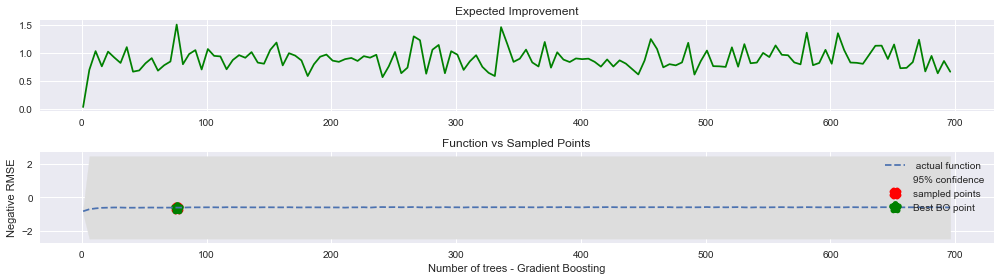

STEP NUMBER = 1
Bayesian Optimization just sampled point = [151]
Best x (Bayesian Optimization) = [151], Best y = -0.5909221928729056


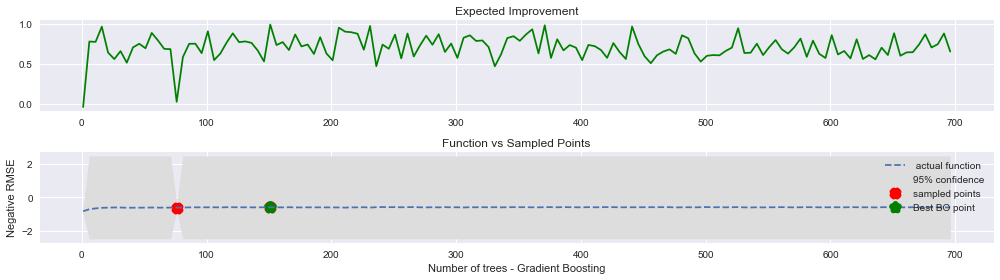

STEP NUMBER = 2


KeyboardInterrupt: 

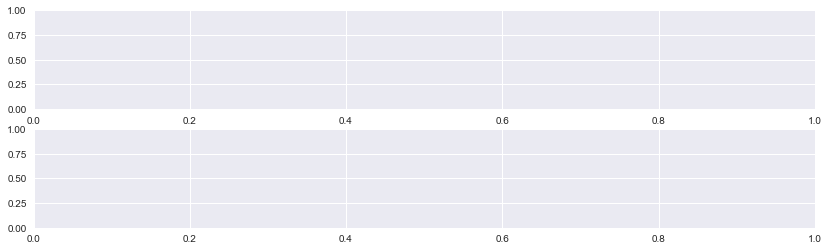

In [42]:
# Used for Expected Improvement 
# For the real function, plot the values
train_y_x_axis = range(1,700,5)
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
    
for i in range(samples):
    print('STEP NUMBER =',i)
    fig, axs = plt.subplots(2, figsize=(14, 4))
     # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    
    
    # Expectd Improvement
    #plt.figure(figsize=(12,10))
    axs[0].set_title('Expected Improvement')
    axs[0].plot(domain,improvements,label='Expected improvements',color='green')
    

     # 95% confidence bars
    #plt.figure(figsize=(12,10))
    axs[1].set_title("Function vs Sampled Points")
    plt.gca().fill_between( domain.flat, mus-2*np.sqrt(sampled_var),
                           mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    # Plot the real function vs sampled points
    axs[1].plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    axs[1].scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    axs[1].scatter(best_x,best_y, marker = "*",label='Best BO point',linewidths=6, color = 'green')
    axs[1].set_ylabel('Negative RMSE')
    axs[1].set_xlabel('Number of trees - Gradient Boosting')
    # update mus and domain
    mus = np.array(mus)
    domain = np.array(domain)
    plt.legend()
    plt.tight_layout()
    plt.show();


# Compare performance of finding the n_estimators to random search and grid search
- Gradient Boosting

In [43]:
def grid_search(range_, h_choice = hyperparam_choice_function, dimensions='one', range_two = None):
    """A generator that methodically searches through the input range and returns the x val(s), and the negative RMSE
   Range should be np.linspace steps = 1k This is the number of steps in the bayesian optimization algo.
   
   Dimensions specifies how the dimensions to return. Currently works with one or two dimensions"""
    if dimensions == 'one':
        for x in range_:
            yield (x,h_choice(x))
    elif dimensions =='two':
        if range_two == None: # same domain for both function
            all_combinations = list(itertools.product(*[range_,range_]))
        else:
            all_combinations = list(itertools.product(*[range_,range_two]))
        for sample in all_combinations:
            yield (sample,h_choice(sample[0], dimensions='two', hyperparameter_value_two = sample[1]))

In [45]:
def random_grid_search(range_, h_choice = hyperparam_choice_function, dimensions = 'one', range_two = None):
    """Random grid search 
    Return a generator that methodically searches through the input range and returns the x val and
    the negative RMSE.
    Range should be np.linspace = 1k, This is the number of steps in the bayesian optimization algo.
    
    The dimensions specifies how many dimensison to return. Currently works with one or two dimensions"""
    sampled_points = []
    if dimensions == 'one':
        for _ in range(len(range_)):
            choice = np.random.choice(range_)
            # don't sample the same point twice
            while choice in sampled_points:
                choice = np.random.choice(range_)
            # append the point we just sampled
            sampled_points.append(choice)
            yield (choice,h_choice(choice))
    elif dimensions == 'two':
        if range_two == None: # same domain for both function
            all_combinations = list(itertools.product(*[range_,range_]))
        else:
            all_combinations = list(itertools.product(*[range_,range_two]))
        for _ in range(len(all_combinations )):
            # randomlly select a row
            row_idx = np.random.choice(len(all_combinations))
            choice = all_combinations[row_idx]
            while choice in sampled_points: # sample again
                row_idx = np.random.choice(len(all_combinations))
                try: # depends if shape is np.array or list
                    choice = all_combinations[row_idx,:] 
                except:
                    choice = all_combinations[row_idx] 
            sampled_points.append(choice)
            yield (choice,h_choice(choice[0], dimensions='two', hyperparameter_value_two = choice[1]))
    else:
        return 'We do not support that number of dimensions yet '
                       
            
            

In [46]:
# random gridsearch gen
rand_grid_gen =  random_grid_search(range(1,700,5))
# gridsearch gen
grid_gen = random_grid_search(range(1,700,5))
# BAYESIAN OPTIMIZATION generator
train_x_hyp = np.array(3).reshape(-1,1)
train_y_hyp = np.array([hyperparam_choice_function(i[0]) for i in train_x_hyp]).reshape(-1,1)
samples = 10
gen_hyp_bo = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(1,700,5), n=samples )

STEP NUMBER = 1
Bayesian Optimization just sampled point = [366]
Best x (Bayesian Optimization) = [366], Best y = -0.5810187731096741

Grid search just sampled point = 561
Best X (Grid Search) = 561, Best y = -0.5919106290142191

Random Grid search just sampled point = 666
Best X (Random Grid Search) = 561, Best y = -0.5899968909376515


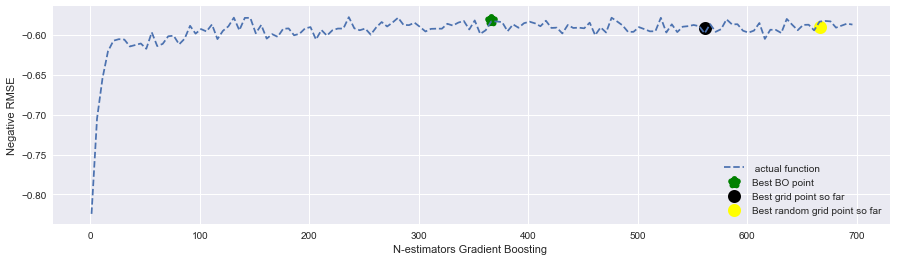

STEP NUMBER = 2
Bayesian Optimization just sampled point = [326]
Best x (Bayesian Optimization) = [366], Best y = -0.5810187731096741

Grid search just sampled point = 536
Best X (Grid Search) = 536, Best y = -0.5880515169537736

Random Grid search just sampled point = 441
Best X (Random Grid Search) = 536, Best y = -0.5794092000010652


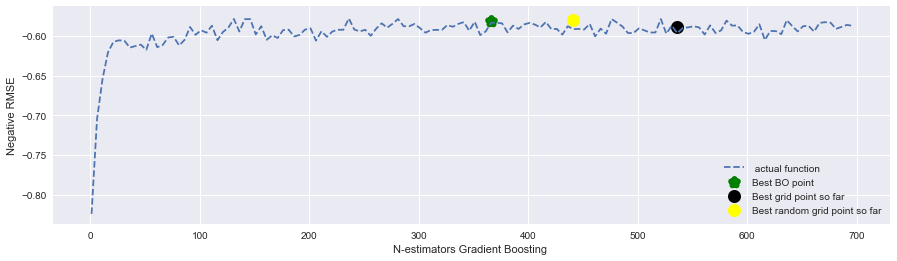

STEP NUMBER = 3
Bayesian Optimization just sampled point = [546]
Best x (Bayesian Optimization) = [366], Best y = -0.5810187731096741

Grid search just sampled point = 386
Best X (Grid Search) = 386, Best y = -0.5818406656171178

Random Grid search just sampled point = 306
Best X (Random Grid Search) = 386, Best y = -0.5794092000010652


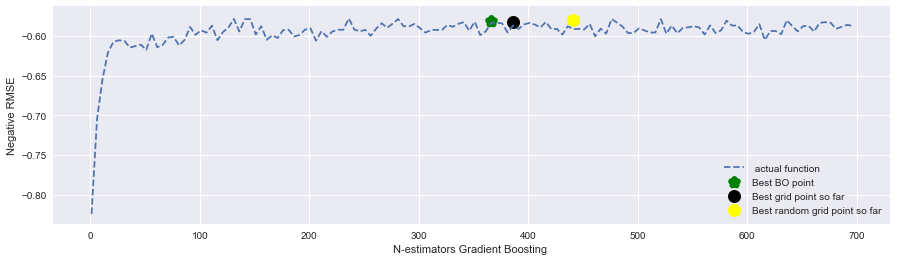

STEP NUMBER = 4


KeyboardInterrupt: 

In [47]:
# Plot Bayesian Optimization vs grid search
# For the real function, plot the values
train_y_x_axis = np.array(range(1,700,5))
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
# keep track of best points for grid search
best_y_grid = -9999999
best_x_grid = None
sampled_x_grid = []
sampled_y_grid = []
# keep track of best points for random grid search
best_y_grid_rand = -9999999
best_x_grid_rand = None
sampled_x_grid_rand = []
sampled_y_grid_rand = []

for i in range(samples):

    print('STEP NUMBER =',i+1)
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x_bo, best_y_bo, improvements, domain, mus = next(gen_hyp_bo)
    # sample from gridsearch
    x_grid, y_grid = next(grid_gen)
    #sample from random gridsearch
    x_grid_rand, y_grid_rand = next(rand_grid_gen) 
    
    # keep track of best gridsearch parameters
    if y_grid > best_y_grid:
        best_y_grid = y_grid
        best_x_grid = x_grid
    if y_grid_rand > best_y_grid_rand:
        best_y_grid_rand = y_grid_rand
        best_x_grid_rand = x_grid_rand
    # append these points to the list we are keeping track of for grid search 
    sampled_x_grid.append(x_grid)
    sampled_y_grid.append(y_grid)
    sampled_x_grid_rand.append(x_grid_rand)
    sampled_y_grid_rand.append(y_grid_rand)
    print()
    print(f"Grid search just sampled point = {x_grid}")
    print(f"Best X (Grid Search) = {best_x_grid}, Best y = {best_y_grid}")
    print()
    print(f"Random Grid search just sampled point = {x_grid_rand}")
    print(f"Best X (Random Grid Search) = {best_x_grid}, Best y = {best_y_grid_rand}")
    
    #plot actual function
    plt.figure(figsize=(15,4))
    plt.plot(train_y_x_axis, train_y_numbers_, label=' actual function',linestyle="--")
    plt.ylabel('Negative RMSE')
    plt.xlabel('N-estimators Gradient Boosting ')
    
    # Results so far from bayesian optimization
    # All sampled points, use code bleow to display
    #plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points - BO',linewidths=5)
    plt.scatter(best_x_bo,best_y_bo, marker = "*",label='Best BO point',linewidths=6, color = 'green') # best point
    
    # Results from grid search
    # All sampled points, below
    #plt.scatter(sampled_x_grid,sampled_y_grid, marker = 'o', label='Grid Search points', color='orange',linewidths=6)
    plt.scatter(best_x_grid,best_y_grid , label='Best grid point so far', linewidths=6, color = 'Black')
    
    # Results from random grid search
    # All sampled points below
    #plt.scatter(sampled_x_grid_rand, sampled_y_grid_rand, marker = 'o', label='Random Grid Search points', color='maroon',linewidths=6)
    plt.scatter(best_x_grid_rand, best_y_grid_rand , label='Best random grid point so far', linewidths=6, color = 'Yellow')
    
    plt.legend()
    plt.show();

# Run this optimization 20 times with step size 10 and see how many times each optimization method wins
## One dimensional search
- Each optimization is looking at domain [1,700,5] for the number of estimators ( trees)
- step size is the number of 'steps' that each optimization algorithm will take
- Use squarred kernel for Bayesian Optimization


In [33]:
grid_wins = 0 # number of time sthat grid search won
random_grid_wins = 0 # number of time that random grid search won
bo_wins = 0 # number of times bayesian optimization won
n_trials = 20
samples = 10
for trial in range(n_trials):
    print('TRIAL NUMBER = ',trial+1)
    # initialize new generators for each trial
    # random gridsearch gen
    rand_grid_gen =  random_grid_search(range(1,700,5))
    # gridsearch gen
    grid_gen = grid_search(range(1,700,5))
    # BAYESIAN OPTIMIZATION generator
    gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                                   squarred_kernel, y_var_hyp, testing_domain = range(1,700,5), n=samples, verbose=False )


    # keep track of best points for grid search
    best_y_grid = -9999999
    best_x_grid = None
    sampled_x_grid = []
    sampled_y_grid = []
    # keep track of best points for random grid search
    best_y_grid_rand = -9999999
    best_x_grid_rand = None
    sampled_x_grid_rand = []
    sampled_y_grid_rand = []

    for iteration in range(samples): # iteration is the number of steps for each optimizer to take 
        #sample from generator
        x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
        # sample from gridsearch
        x_grid, y_grid = next(grid_gen)
        #sample from random gridsearch
        x_grid_rand, y_grid_rand = next(rand_grid_gen) 
        # keep track of best gridsearch parameters
        if y_grid > best_y_grid:
            best_y_grid = y_grid
            best_x_grid = x_grid
        if y_grid_rand > best_y_grid_rand:
            best_y_grid_rand = y_grid_rand
            best_x_grid_rand = x_grid_rand
            
    if (best_y_grid_rand > best_y_grid) & (best_y_grid_rand > best_y):
        print('Random Grid Search had the best parameter')
        random_grid_wins+=1
    elif (best_y_grid > best_y) & (best_y_grid>best_y_grid_rand):
        print("Grid Search had the best parameter")
        grid_wins+=1
    else:# BO was the best
        print('Bayesian optimization had the  best parameter')
        bo_wins+=1
        

        
        

TRIAL NUMBER =  1
Bayesian optimization had the  best parameter
TRIAL NUMBER =  2
Bayesian optimization had the  best parameter
TRIAL NUMBER =  3
Bayesian optimization had the  best parameter
TRIAL NUMBER =  4
Random Grid Search had the best parameter
TRIAL NUMBER =  5
Bayesian optimization had the  best parameter
TRIAL NUMBER =  6
Bayesian optimization had the  best parameter
TRIAL NUMBER =  7
Random Grid Search had the best parameter
TRIAL NUMBER =  8
Random Grid Search had the best parameter
TRIAL NUMBER =  9
Bayesian optimization had the  best parameter
TRIAL NUMBER =  10
Bayesian optimization had the  best parameter
TRIAL NUMBER =  11
Bayesian optimization had the  best parameter
TRIAL NUMBER =  12
Bayesian optimization had the  best parameter
TRIAL NUMBER =  13
Bayesian optimization had the  best parameter
TRIAL NUMBER =  14
Bayesian optimization had the  best parameter
TRIAL NUMBER =  15
Bayesian optimization had the  best parameter
TRIAL NUMBER =  16
Bayesian optimization had t

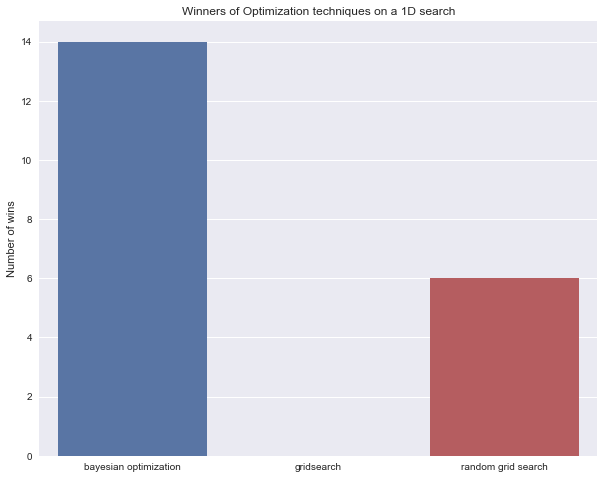

In [34]:
plt.figure(figsize=(10,8))
sns.barplot(x=['bayesian optimization','gridsearch','random grid search'],y=[bo_wins ,grid_wins , random_grid_wins  ])
plt.ylabel('Number of wins')
plt.title('Winners of Optimization techniques on a 1D search')

- Random grid search works pretty well in one dimesion. However, as the dimensionality increases, then Bayesian optimization should continue to perform better.

# Test two dimensions using Squarred Kernel

## Visualize what the surface of n_estimators + max_depth

In [48]:
hyper_param_range_estimators = range(1,700,5)
hyper_param_range_depth = range(1,50)
combo_hyperparam = list(itertools.product(*[hyper_param_range_estimators,hyper_param_range_depth]))
# for the 3d plot
xs = [combo_hyperparam[i][0] for i in range(len(combo_hyperparam))]
ys = [combo_hyperparam[i][1] for i in range(len(combo_hyperparam))]

In [49]:
print(f" The total number of 2D parameters to search are {len(combo_hyperparam)}")

 The total number of 2D parameters to search are 6860


In [50]:
y_vals_grad_boost = np.array([hyperparam_choice_function(i[0], dimensions='two', 
                              hyperparameter_value_two= i[1]) for i in combo_hyperparam ])

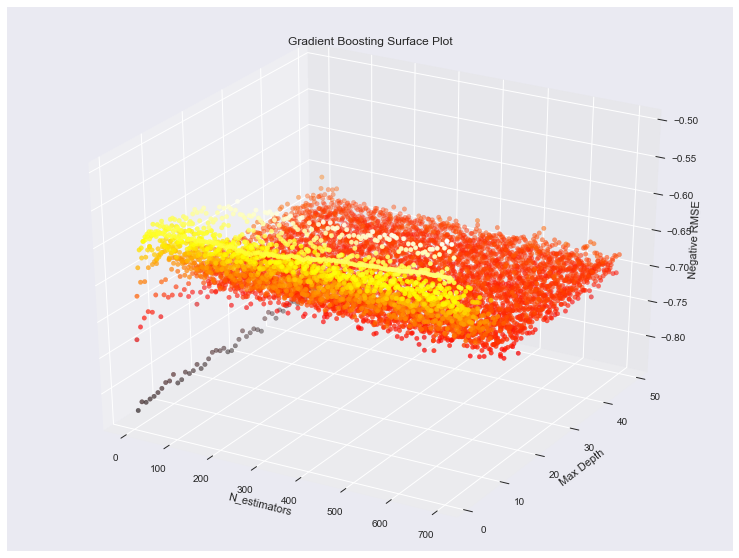

In [58]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('Negative RMSE')
ax.set_xlabel('N_estimators')
ax.set_ylabel('Max Depth')
ax.scatter (xs, ys,y_vals_grad_boost, cmap='hot', c=y_vals_grad_boost)
plt.title('Gradient Boosting Surface Plot');

In [51]:


train_x_hyp_idx = np.array(np.random.choice(len(combo_hyperparam)))
train_x_hyp_2d = np.array([combo_hyperparam[train_x_hyp_idx ]])

train_y_hyp_2d = np.array([[hyperparam_choice_function(train_x_hyp_2d[0][0], dimensions='two', 
                                            hyperparameter_value_two= train_x_hyp_2d[0][1]) for i in train_x_hyp]])
y_var_hyp_2d = 5

In [52]:
# Create the generator, TWO DIMENSIONAL
samples = 10
gen_two_d = sample_from_function(hyperparam_choice_function, train_x_hyp_2d,
                                 train_y_hyp_2d , squarred_kernel, y_var_hyp_2d, n=samples,
                                 testing_domain=combo_hyperparam )


In [53]:
# grid search generator
gen_2d_grid = grid_search(hyper_param_range_estimators, dimensions='two', range_two= hyper_param_range_depth)

In [54]:
# random grid search generator
gen_2d_grid_rand = random_grid_search(hyper_param_range_estimators,dimensions='two', range_two = hyper_param_range_depth)

STEP NUMBER = 1
Bayesian Optimization just sampled point = (156, 14)
Best x (Bayesian Optimization) = (156, 14), Best y = -0.6506180258437112

Grid search just sampled point = (1, 1)
Best X (Grid Search) = (1, 1), Best y = -0.8287225030091963

Random Grid search just sampled point = (386, 14)
Best X (Random Grid Search) = (386, 14), Best y = -0.63593213715725


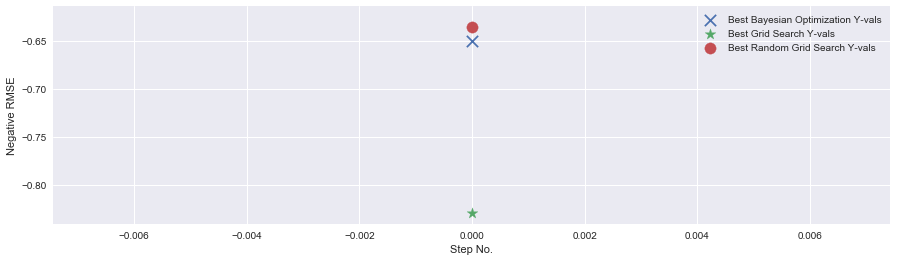

STEP NUMBER = 2
Bayesian Optimization just sampled point = (201, 14)
Best x (Bayesian Optimization) = (201, 14), Best y = -0.6492624731124049

Grid search just sampled point = (1, 2)
Best X (Grid Search) = (1, 2), Best y = -0.8200216860660511

Random Grid search just sampled point = (236, 44)
Best X (Random Grid Search) = (386, 14), Best y = -0.63593213715725


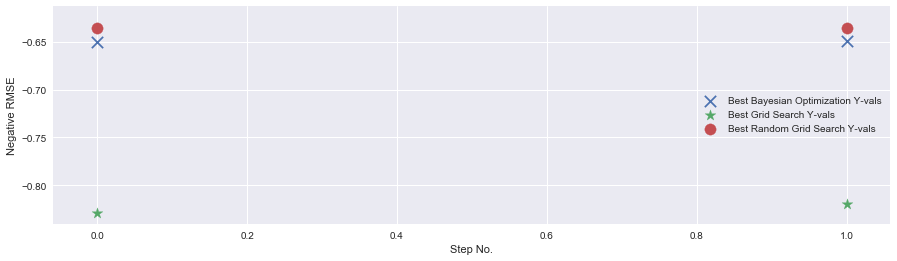

STEP NUMBER = 3
Bayesian Optimization just sampled point = (61, 22)
Best x (Bayesian Optimization) = (201, 14), Best y = -0.6492624731124049

Grid search just sampled point = (1, 3)
Best X (Grid Search) = (1, 2), Best y = -0.8200216860660511

Random Grid search just sampled point = (326, 34)
Best X (Random Grid Search) = (386, 14), Best y = -0.63593213715725


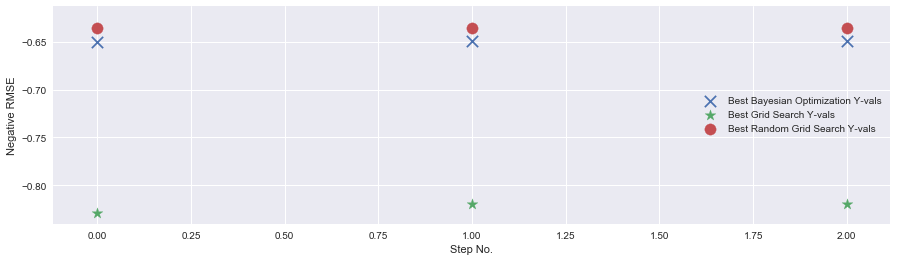

STEP NUMBER = 4


KeyboardInterrupt: 

In [127]:
# keep track of what step number we are on
step_x_axis = []
# bes bayesian optimization points
best_y_bo_2d = []
# keep track of best points for grid search
best_y_grid_2d_value = -9999999
best_x_grid_2d = None
sampled_x_grid_2d = []
sampled_y_grid_2d = []
best_y_grid_2d = []
# keep track of best points for random grid search
best_y_grid_rand_2d_value = -9999999
best_x_grid_rand_2d = None
sampled_x_grid_rand_2d = []
sampled_y_grid_rand_2d = []
best_y_grid_rand_2d = []


for i in range(samples): # TWO D
    # plot step  vs y-values for each algo
    step_x_axis.append(i)
    
    print('STEP NUMBER =',i+1)
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus =next(gen_two_d)

    # sample from gridsearch
    x_grid_2d, y_grid_2d = next(gen_2d_grid )
    
    #sample from random gridsearch
    x_grid_rand_2d, y_grid_rand_2d = next(gen_2d_grid_rand) 
    
    # keep track of best gridsearch parameters
    if y_grid_2d > best_y_grid_2d_value:
        best_y_grid_2d_value = y_grid_2d
        best_x_grid_2d = x_grid_2d
    if y_grid_rand_2d > best_y_grid_rand_2d_value:
        best_y_grid_rand_2d_value = y_grid_rand_2d
        best_x_grid_rand_2d = x_grid_rand_2d
    # append these points to the list we are keeping track of for grid search 
    sampled_x_grid_2d.append(x_grid_2d)
    sampled_y_grid_2d.append(y_grid_2d)
    best_y_grid_2d.append(best_y_grid_2d_value )
    # random grid search
    sampled_x_grid_rand_2d.append(x_grid_rand_2d)
    sampled_y_grid_rand_2d.append(y_grid_rand_2d)
    best_y_grid_rand_2d.append(best_y_grid_rand_2d_value)
    # BO best y
    best_y_bo_2d.append(best_y)
    print()
    print(f"Grid search just sampled point = {x_grid_2d}")
    print(f"Best X (Grid Search) = {best_x_grid_2d}, Best y = {best_y_grid_2d_value}")
    print()
    print(f"Random Grid search just sampled point = {x_grid_rand_2d}")
    print(f"Best X (Random Grid Search) = {best_x_grid_rand_2d}, Best y = {best_y_grid_rand_2d_value}")
    plt.figure(figsize=(15,4))
    plt.scatter(step_x_axis, best_y_bo_2d, label='Best Bayesian Optimization Y-vals', s=128, marker='x')
    plt.scatter(step_x_axis, best_y_grid_2d ,label='Best Grid Search Y-vals', s=128,marker='*')
    plt.scatter(step_x_axis, best_y_grid_rand_2d ,label='Best Random Grid Search Y-vals' ,s=128, 
                marker='o')
    plt.legend()
    plt.ylabel('Negative RMSE')
    plt.xlabel('Step No.')
    plt.show();
    


# Test over ten trials in two-dimensions each algorithm
- Investigating n_estimators + max_depth to predict alcohol in the test wine dataset 
- Ten steps per trial

In [95]:
grid_wins = 0 # number of time sthat grid search won
random_grid_wins = 0 # number of time that random grid search won
bo_wins = 0 # number of times bayesian optimization won
# range to search over
hyper_param_range_estimators = range(1,700,5)
hyper_param_range_depth = range(1,50)
combo_hyperparam = list(itertools.product(*[hyper_param_range_estimators,hyper_param_range_depth]))

n_trials = 10
samples = 10
for trial in range(n_trials):
    print('TRIAL NUMBER = ',trial+1)
    # initialize new generators for each trial
    range_2d = np.linspace(0,1) # range to search
    # gridsearch gen
    gen_2d_grid = grid_search(hyper_param_range_estimators, dimensions='two', range_two= hyper_param_range_depth)
    # random gridsearch gen
    gen_2d_grid_rand = random_grid_search(hyper_param_range_estimators,dimensions='two',
                                          range_two = hyper_param_range_depth)
   
    # combo range
    combo_hyperparam = list(itertools.product(*[hyper_param_range_estimators,hyper_param_range_depth]))

    train_x_hyp_idx = np.array(np.random.choice(len(combo_hyperparam)))
    train_x_hyp_2d = np.array([combo_hyperparam[train_x_hyp_idx]])

    train_y_hyp_2d = np.array([hyperparam_choice_function(train_x_hyp_2d[0][0], dimensions='two', 
                                                hyperparameter_value_two= train_x_hyp_2d[0][1]) for i in train_x_hyp])
    y_var_hyp_2d = 5
    gen_bo_two_d = sample_from_function(hyperparam_choice_function, train_x_hyp_2d,
                                     train_y_hyp_2d.reshape(-1,1) , squarred_kernel, y_var_hyp_2d, n=samples,
                                     testing_domain=combo_hyperparam, verbose=False )
    

    # keep track of best points for grid search
    best_y_grid_2d = -9999999
    best_x_grid_2d = None
    sampled_x_grid_2d = []
    sampled_y_grid_2d = []
    # keep track of best points for random grid search
    best_y_grid_rand_2d = -9999999
    best_x_grid_rand_2d = None
    sampled_x_grid_rand_2d = []
    sampled_y_grid_rand_2d = []

    for iteration in range(samples): # iteration is the number of steps for each optimizer to take 
        #sample from generator
        x_sampled_points, y_sampled_points, sampled_var, best_x_2d, best_y_2d, improvements, domain, mus = next(
            gen_bo_two_d )
        # sample from gridsearch
        x_grid_2d, y_grid_2d = next(gen_2d_grid)
        #sample from random gridsearch
        x_grid_rand_2d, y_grid_rand_2d = next(gen_2d_grid_rand) 
        # keep track of best gridsearch parameters
        if y_grid_2d > best_y_grid_2d:
            best_y_grid_2d = y_grid_2d
            best_x_grid_2d = x_grid_2d
        if y_grid_rand_2d > best_y_grid_rand_2d:
            best_y_grid_rand_2d = y_grid_rand_2d
            best_x_grid_rand_2d = x_grid_rand_2d
            
    if (best_y_grid_rand_2d > best_y_grid_2d) & (best_y_grid_rand > best_y_2d):
        print('Random Grid Search had the best parameter')
       
        random_grid_wins+=1
    elif (best_y_grid_2d > best_y_2d) & (best_y_grid_2d > best_y_grid_rand_2d):
        print("Grid Search had the best parameter")
        grid_wins+=1
    else:# BO was the best
        print('Bayesian optimization had the  best parameter')
        bo_wins+=1
        

        
        

TRIAL NUMBER =  1
Bayesian optimization had the  best parameter
TRIAL NUMBER =  2
Bayesian optimization had the  best parameter
TRIAL NUMBER =  3
Random Grid Search had the best parameter
TRIAL NUMBER =  4
Random Grid Search had the best parameter
TRIAL NUMBER =  5
Bayesian optimization had the  best parameter
TRIAL NUMBER =  6
Bayesian optimization had the  best parameter
TRIAL NUMBER =  7
Random Grid Search had the best parameter
TRIAL NUMBER =  8
Bayesian optimization had the  best parameter
TRIAL NUMBER =  9
Bayesian optimization had the  best parameter
TRIAL NUMBER =  10
Bayesian optimization had the  best parameter


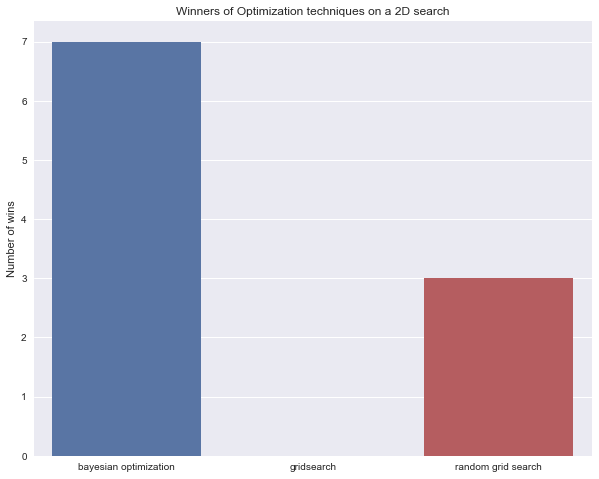

In [96]:
plt.figure(figsize=(10,8))
sns.barplot(x=['bayesian optimization','gridsearch','random grid search'],y=[bo_wins ,grid_wins , random_grid_wins  ])
plt.ylabel('Number of wins')
plt.title('Winners of Optimization techniques on a 2D search')

In [97]:
print(f" In searching for the best hyperparameters using Bayesian Optimization  \
      to predict alcohol percent, the best n_estimators was {best_x_2d[0]} , and the best max_depth was {best_x_2d[1]}")

 In searching for the best hyperparameters using Bayesian Optimization        to predict alcohol percent, the best n_estimators was 561 , and the best max_depth was 4


In [99]:
print(f"The best negative RMSE was {best_y_2d} for Bayesian Optimization")

The best negative RMSE was -0.554390956860365 for Bayesian Optimization
